# Inverse FaIR
This notebook gives an example of running FaIR in reverse: given concentrations of CO2, diagnose the emissions.

In [1]:
import numpy as np
from scipy.optimize import root
from fair.forward import forc_to_temp, calculate_q, iirf_simple, iirf_interp
from fair.forcing.ghg import co2_log
from fair.defaults import carbon, thermal
from fair.constants import molwt
from fair.constants.general import M_ATMOS

In [2]:
def infer_emissions(e1, c1_prescribed, carbon_boxes0, tau_new, a, ppm_gtc, c_pi):
    c1_calculated = np.sum(carbon_boxes0*np.exp(-1.0/tau_new) + a*e1 / ppm_gtc) + c_pi
    return c1_calculated-c1_prescribed


def inverse_carbon_cycle(c1, c_acc0, temp, r0, rc, rt, iirf_max, time_scale_sf, a,
                     tau, iirf_h, carbon_boxes0, ppm_gtc, c_pi, c0, e0):

    iirf = iirf_simple(c_acc0, temp, r0, rc, rt, iirf_max)
    time_scale_sf = root(iirf_interp, time_scale_sf,
      args=(a, tau, iirf_h, iirf))['x']
    tau_new = tau * time_scale_sf
    e1 = root(infer_emissions, e0, args=(c1, carbon_boxes0, tau_new, a, ppm_gtc, c_pi))['x']
    c_acc1 = c_acc0 + 0.5*(e1 + e0) - (c1 - c0)*ppm_gtc
    #print carbon_boxes0.shape, tau_new.shape, a.shape, e1.shape
    carbon_boxes1 = carbon_boxes0*np.exp(-1.0/tau_new) + a*e1 / ppm_gtc
    return e1, c_acc1, carbon_boxes1, time_scale_sf

## Test with a 1% CO2 run

In [3]:
nt = 140
c         = 1.01**np.arange(nt) * 278.
c_acc     = np.zeros(nt)
carbon_boxes = np.zeros((nt,4))
emissions = np.zeros(nt) # this is the solution vector
T_j       = np.zeros((nt,2))
r0        = carbon.r0
rc        = carbon.rc
rt        = carbon.rt
iirf_max  = carbon.iirf_max
time_scale_sf = 0.16
a         = carbon.a
tau       = carbon.tau
iirf_h    = carbon.iirf_h
ppm_gtc   = M_ATMOS/1e18*molwt.C/molwt.AIR
c_pi      = 278.
F         = np.zeros(nt)

In [4]:
tcrecs  = np.array([1.7, 3.0])
d       = thermal.d
f2x     = thermal.f2x
tcr_dbl = thermal.tcr_dbl
q       = calculate_q(tcrecs, d, f2x, tcr_dbl, nt)

emissions[0] = root(infer_emissions, 0., args=(c[0], carbon_boxes[0], tau, a, ppm_gtc, c_pi))['x']
F[0]         = co2_log(c[0], c_pi, F2x=f2x)
T_j[0,:]     = forc_to_temp(T_j[0,:], q[0,:], d, F[0])
time_scale_sf= 0.16

for t in range(1,nt):
    emissions[t], c_acc[t], carbon_boxes[t,:], time_scale_sf = inv_carbon_cycle(
        c[t], c_acc[t-1], np.sum(T_j[t-1,:]), r0, rc, rt, iirf_max, time_scale_sf, a,
        tau, iirf_h, carbon_boxes[t-1,:], ppm_gtc, c_pi, c[t-1], emissions[t-1])
    F[t] = co2_log(c[t], c_pi)
    T_j[t,:] = forc_to_temp(T_j[t-1,:], q[t,:], d, F[t])

T = np.sum(T_j, axis=-1)

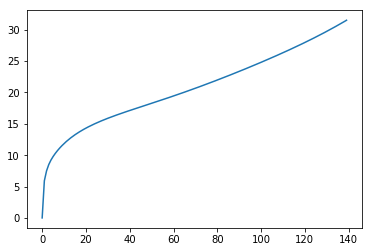

In [5]:
import matplotlib.pyplot as pl
%matplotlib inline
pl.plot(emissions)

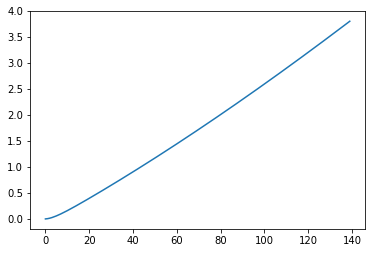

In [6]:
pl.plot(T)

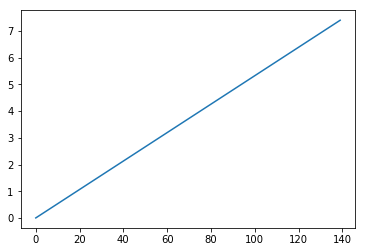

In [7]:
pl.plot(F)

In this example, turn off the temperature feedback on carbon cycle

In [8]:
c_acc2     = np.zeros(nt)
carbon_boxes2 = np.zeros((nt,4))
emissions2 = np.zeros(nt) # this is the solution vector
T_j2       = np.zeros((nt,2))
rt        = 0.
F2         = np.zeros(nt)

emissions2[0] = root(infer_emissions, 0., args=(c[0], carbon_boxes2[0], tau, a, ppm_gtc, c_pi))['x']
F2[0]         = co2_log(c[0], c_pi, F2x=f2x)
T_j2[0,:]     = forc_to_temp(T_j2[0,:], q[0,:], d, F2[0])
time_scale_sf= 0.16

for t in range(1,nt):
    emissions2[t], c_acc[t], carbon_boxes2[t,:], time_scale_sf = inv_carbon_cycle(
        c[t], c_acc2[t-1], np.sum(T_j2[t-1,:]), r0, rc, rt, iirf_max, time_scale_sf, a,
        tau, iirf_h, carbon_boxes2[t-1,:], ppm_gtc, c_pi, c[t-1], emissions2[t-1])
    F2[t] = co2_log(c[t], c_pi)
    T_j2[t,:] = forc_to_temp(T_j2[t-1,:], q[t,:], d, F2[t])

T2 = np.sum(T_j2, axis=-1)

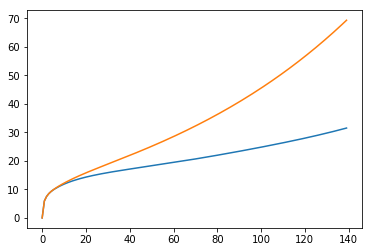

In [9]:
pl.plot(emissions)
pl.plot(emissions2)